# The Detrended Stack

The purpose of this notebook is to reproduce the detrended stack and synthetic stack from the paper. 

In [1]:
import pickle
import copy

import pyleoclim as pyleo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.transforms as transforms

from matplotlib.ticker import FormatStrFormatter

In [2]:
with open('../data/preprocessed_series_dict.pkl','rb') as handle:
    preprocessed_series_dict = pickle.load(handle)

with open('../data/preprocessed_ens_dict.pkl','rb') as handle:
    preprocessed_ens_dict = pickle.load(handle)

with open('../data/pos_dict.pkl','rb') as handle:
    pos_dict = pickle.load(handle)

We begin with the real series, loading the necessary data and sorting by latitude.

In [3]:
lat_dict = {series.lat:series.label for series in preprocessed_series_dict.values()}

sort_index = np.sort(np.array(list(lat_dict.keys())))[::-1]
sort_label = [lat_dict[lat] for lat in sort_index]
preprocessed_series_dict = {label:preprocessed_series_dict[label] for label in sort_label} #Sort by latitude
preprocessed_ens_dict = {label:preprocessed_ens_dict[label] for label in sort_label} #Sort by latitude

The chron data is stored in two files, which we load and combine here.

In [4]:
with open('../data/chron_all.pkl','rb') as handle:
    chron_all1 = pickle.load(handle)

with open('../data/chron_all_2.pkl','rb') as handle:
    chron_all2 = pickle.load(handle)

chron_all = chron_all1 | chron_all2

In [5]:
with open('../data/holo_chrons_study.pkl','rb') as handle:
    holo_chrons = pickle.load(handle)

Now we plot:

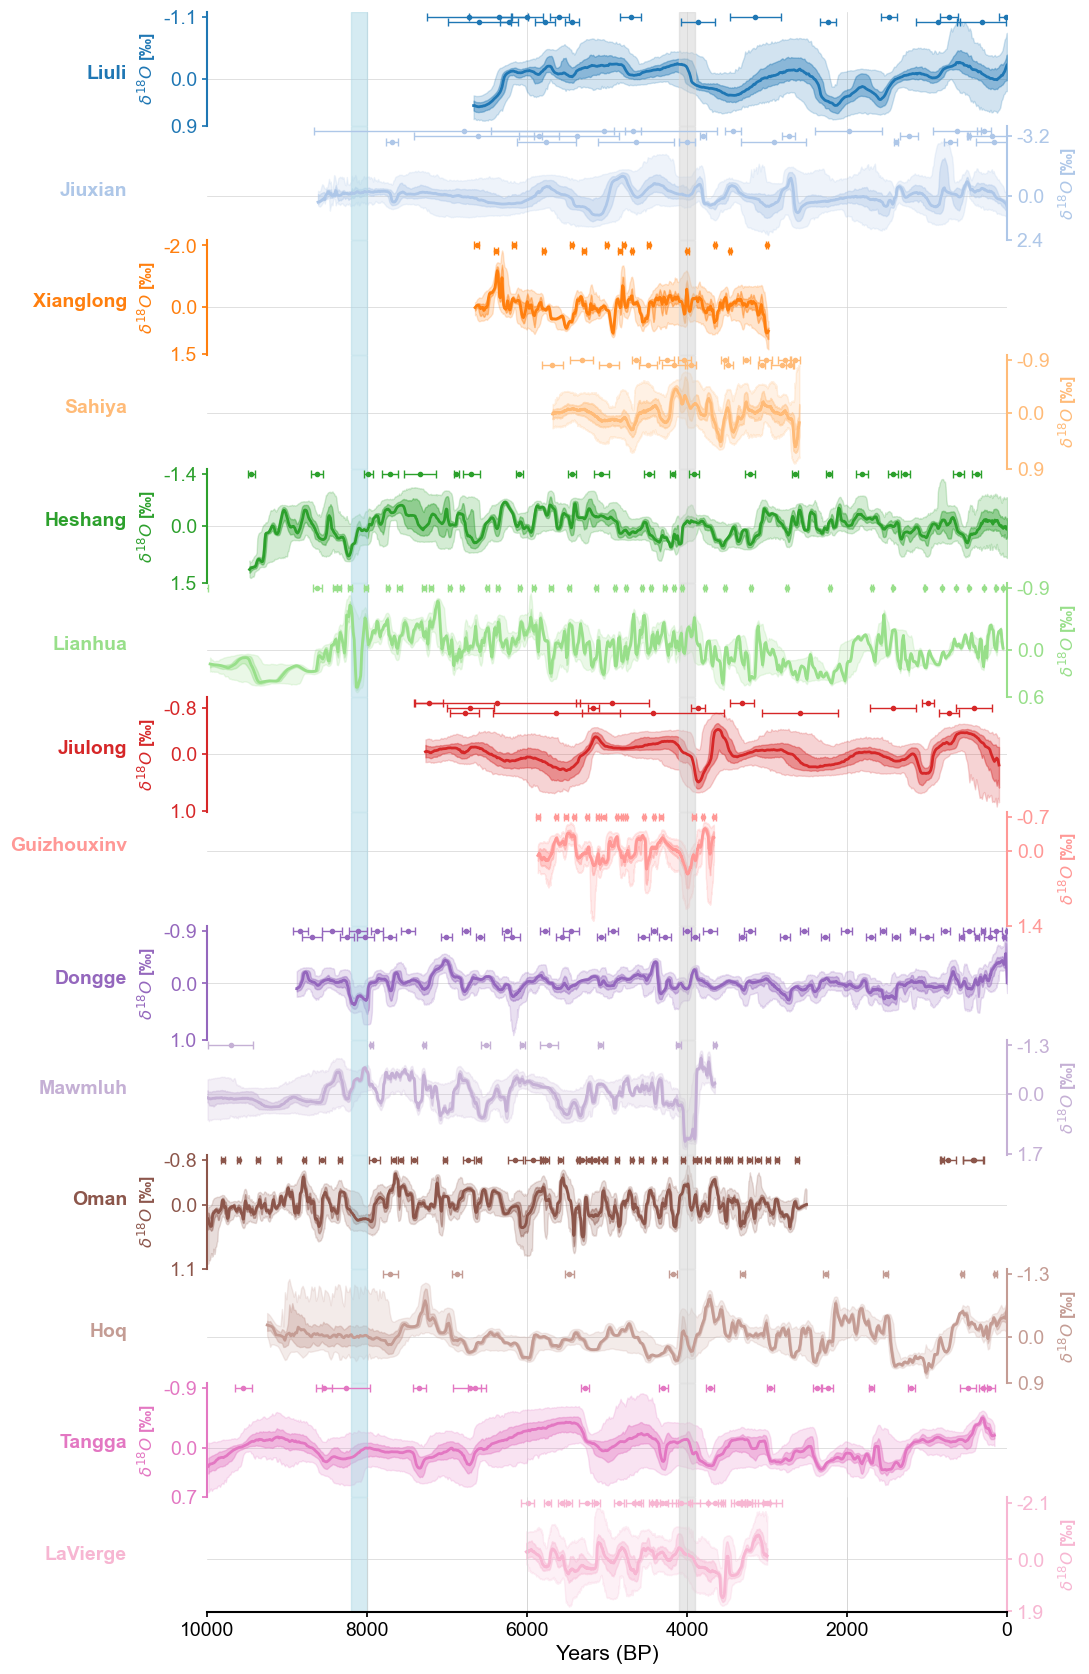

In [6]:
# Create a figure with a specified size
fig = plt.figure(figsize=(8, 16))

# Set up plot parameters
xlim = [0, 10000]
n_ts = len(preprocessed_ens_dict)
fill_between_alpha = 0.2
cmap = 'tab20'
labels = 'auto'
ylabel_fontsize = 12
spine_lw = 1.5
grid_lw = 0.5
label_x_loc = -0.15
v_shift_factor = 1
linewidth = 1.5

ax = {}
left = 0
width = 1
height = 1 / n_ts
bottom = 1

# Create a color palette with the same number of colors as the length of preprocessed_ens_dict
colors = sns.color_palette('tab20', n_colors=len(preprocessed_ens_dict))

# Iterate over each pair in preprocessed_ens_dict
for idx, pair in enumerate(preprocessed_ens_dict.items()):
    color = colors[idx]
    label, ens = pair
    bottom -= height * v_shift_factor
    ax[idx] = fig.add_axes([left, bottom, width, height])
    
    # Plot the ensemble envelope
    ens.common_time(time_axis=preprocessed_series_dict[label].time, bounds_error=False).plot_envelope(ax=ax[idx], shade_clr=color, curve_clr=color)
    
    # Set plot properties for the main axis
    ax[idx].patch.set_alpha(0)
    ax[idx].set_xlim(xlim)
    time_label = 'Years (BP)'
    value_label = '$\delta^{18} O$ [‰]'
    ax[idx].set_ylabel(value_label, weight='bold', size=ylabel_fontsize)
    
    # Add labels to the plot
    trans = transforms.blended_transform_factory(ax[idx].transAxes, ax[idx].transData)
    ax[idx].text(-.1, 0, label, horizontalalignment='right', transform=trans, color=color, weight='bold')
    ylim = ax[idx].get_ylim()
    ax[idx].set_yticks([ylim[0], 0, ylim[-1]])
    ax[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[idx].grid(False)
    
    # Set spine and tick properties based on index
    if idx % 2 == 0:
        ax[idx].spines['left'].set_visible(True)
        ax[idx].spines['left'].set_linewidth(spine_lw)
        ax[idx].spines['left'].set_color(color)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].yaxis.set_label_position('left')
        ax[idx].yaxis.tick_left()
    else:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(True)
        ax[idx].spines['right'].set_linewidth(spine_lw)
        ax[idx].spines['right'].set_color(color)
        ax[idx].yaxis.set_label_position('right')
        ax[idx].yaxis.tick_right()
    
    # Add error bars to the plot based on the label
    ylim_mag = max(ylim) - min(ylim)
    offset = ylim_mag * .05
    if label in ['Xianglong', 'Dongge', 'Sahiya', 'Liuli']:
        ax[idx].errorbar(holo_chrons[label]['dating_age'][0::2], [ylim[0]] * len(holo_chrons[label]['dating_age'][0::2]), xerr=holo_chrons[label]['dating_error'][0::2], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][1::2], [ylim[0] + offset] * len(holo_chrons[label]['dating_age'][1::2]), xerr=holo_chrons[label]['dating_error'][1::2], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    elif label in ['Jiuxian', 'Jiulong']:
        ax[idx].errorbar(holo_chrons[label]['dating_age'][0::3], [ylim[0]] * len(holo_chrons[label]['dating_age'][0::3]), xerr=holo_chrons[label]['dating_error'][0::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][1::3], [ylim[0] + offset] * len(holo_chrons[label]['dating_age'][1::3]), xerr=holo_chrons[label]['dating_error'][1::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][2::3], [ylim[0] - offset] * len(holo_chrons[label]['dating_age'][2::3]), xerr=holo_chrons[label]['dating_error'][2::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    else:
        ax[idx].errorbar(holo_chrons[label]['dating_age'], [ylim[0]] * len(holo_chrons[label]['dating_age']), xerr=holo_chrons[label]['dating_error'], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    
    # Set additional plot properties
    ax[idx].yaxis.label.set_color(color)
    ax[idx].tick_params(axis='y', colors=color)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].tick_params(axis='x', which='both', length=0)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels([])
    ax[idx].legend([])
    xt = ax[idx].get_xticks()[1:-1]
    for x in xt:
        ax[idx].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].axhline(y=0, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].invert_xaxis()
    ax[idx].invert_yaxis()
    ax[idx].axvspan(4100, 3900, color='lightgrey', alpha=0.5)
    ax[idx].axvspan(8200,8000,color='lightblue',alpha=0.5)

# Set up the x-axis label at the bottom
bottom -= height * (1 - v_shift_factor)
ax[n_ts] = fig.add_axes([left, bottom, width, height])
ax[n_ts].set_xlabel(time_label)
ax[n_ts].spines['left'].set_visible(False)
ax[n_ts].spines['right'].set_visible(False)
ax[n_ts].spines['bottom'].set_visible(True)
ax[n_ts].spines['bottom'].set_linewidth(spine_lw)
ax[n_ts].set_yticks([])
ax[n_ts].patch.set_alpha(0)
ax[n_ts].set_xlim(xlim)
ax[n_ts].grid(False)
ax[n_ts].tick_params(axis='x', which='both', length=3.5)
xt = ax[n_ts].get_xticks()[1:-1]
for x in xt:
    ax[n_ts].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
ax[n_ts].invert_xaxis()
ax[n_ts].invert_yaxis()

In [7]:
pyleo.savefig(fig,'../figures/detrended_ensembles.pdf')

Figure saved at: "../../figures/detrended_ensembles.pdf"


Now we load our synthetic series objects and plot these in much the same way as our real data. The workflow we used to create these ensembles is presented in the `Synthetic_Ensemble.ipynb` notebook.

In [8]:
with open('../../data/synthetic_ens_dict.pkl','rb') as handle:
    synthetic_ens_dict = pickle.load(handle)

for sn in synthetic_ens_dict:
    synthetic_ens_dict[sn] = {label:synthetic_ens_dict[sn][label] for label in sort_label} #Sort by latitude

SNR = .5

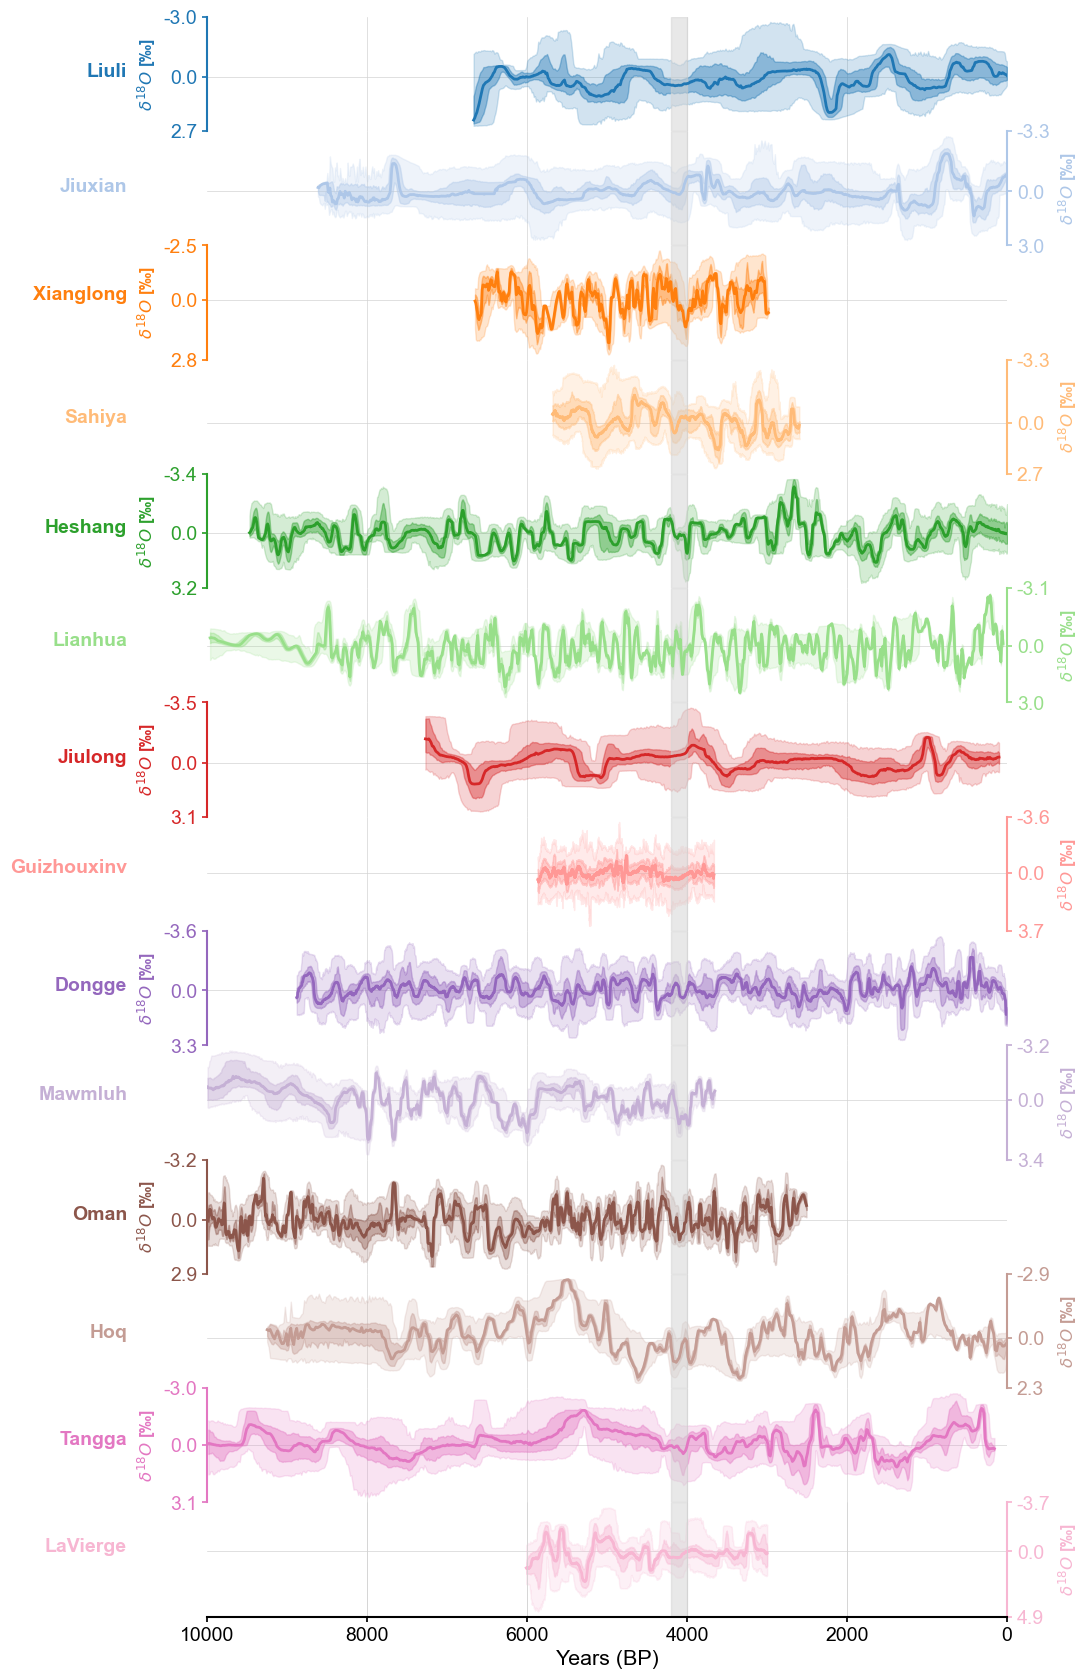

In [9]:
# Create a figure with a specified size
fig = plt.figure(figsize=(8, 16))

# Set up plot parameters
xlim = [0, 10000]
n_ts = len(preprocessed_ens_dict)
fill_between_alpha = 0.2
cmap = 'tab20'
labels = 'auto'
ylabel_fontsize = 12
spine_lw = 1.5
grid_lw = 0.5
label_x_loc = -0.15
v_shift_factor = 1
linewidth = 1.5

ax = {}
left = 0
width = 1
height = 1 / n_ts
bottom = 1

ens_dict = synthetic_ens_dict[.5]
# Create a color palette with the same number of colors as the length of synthetic_ens_dict
colors = sns.color_palette('tab20', n_colors=len(ens_dict))
for idx, pair in enumerate(ens_dict.items()):
    color = colors[idx]
    label, ens = pair
    bottom -= height * v_shift_factor
    
    ax[idx] = fig.add_axes([left, bottom, width, height])


    # Plot the ensemble envelope
    ens.common_time(time_axis=preprocessed_series_dict[label].time, bounds_error=False).plot_envelope(ax=ax[idx], shade_clr=color, curve_clr=color)

    # Set plot properties for the main axis
    ax[idx].patch.set_alpha(0)
    ax[idx].set_xlim(xlim)
    time_label = 'Years (BP)'
    value_label = '$\delta^{18} O$ [‰]'
    ax[idx].set_ylabel(value_label, weight='bold', size=ylabel_fontsize)

    # Add labels to the plot
    trans = transforms.blended_transform_factory(ax[idx].transAxes, ax[idx].transData)
    ax[idx].text(-.1, 0, label, horizontalalignment='right', transform=trans, color=color, weight='bold')
    ylim = ax[idx].get_ylim()
    ax[idx].set_yticks([ylim[0], 0, ylim[-1]])
    ax[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[idx].grid(False)

    # Set spine and tick properties based on index
    if idx % 2 == 0:
        ax[idx].spines['left'].set_visible(True)
        ax[idx].spines['left'].set_linewidth(spine_lw)
        ax[idx].spines['left'].set_color(color)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].yaxis.set_label_position('left')
        ax[idx].yaxis.tick_left()
    else:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(True)
        ax[idx].spines['right'].set_linewidth(spine_lw)
        ax[idx].spines['right'].set_color(color)
        ax[idx].yaxis.set_label_position('right')
        ax[idx].yaxis.tick_right()

    ylim_mag = max(ylim) - min(ylim)
    offset = ylim_mag * .05

    # Set additional plot properties
    ax[idx].yaxis.label.set_color(color)
    ax[idx].tick_params(axis='y', colors=color)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].tick_params(axis='x', which='both', length=0)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels([])
    ax[idx].legend([])
    xt = ax[idx].get_xticks()[1:-1]
    for x in xt:
        ax[idx].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].axhline(y=0, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].invert_xaxis()
    ax[idx].invert_yaxis()
    ax[idx].axvspan(4200, 4000, color='lightgrey', alpha=0.5)

# Set up the x-axis label at the bottom
bottom -= height * (1 - v_shift_factor)
ax[n_ts] = fig.add_axes([left, bottom, width, height])
ax[n_ts].set_xlabel(time_label)
ax[n_ts].spines['left'].set_visible(False)
ax[n_ts].spines['right'].set_visible(False)
ax[n_ts].spines['bottom'].set_visible(True)
ax[n_ts].spines['bottom'].set_linewidth(spine_lw)
ax[n_ts].set_yticks([])
ax[n_ts].patch.set_alpha(0)
ax[n_ts].set_xlim(xlim)
ax[n_ts].grid(False)
ax[n_ts].tick_params(axis='x', which='both', length=3.5)
xt = ax[n_ts].get_xticks()[1:-1]
for x in xt:
    ax[n_ts].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
ax[n_ts].invert_xaxis()
ax[n_ts].invert_yaxis()

In [10]:
pyleo.savefig(fig,'../../figures/synthetic_stack_5.pdf')

Figure saved at: "../../figures/synthetic_stack_5.pdf"


SNR = 1

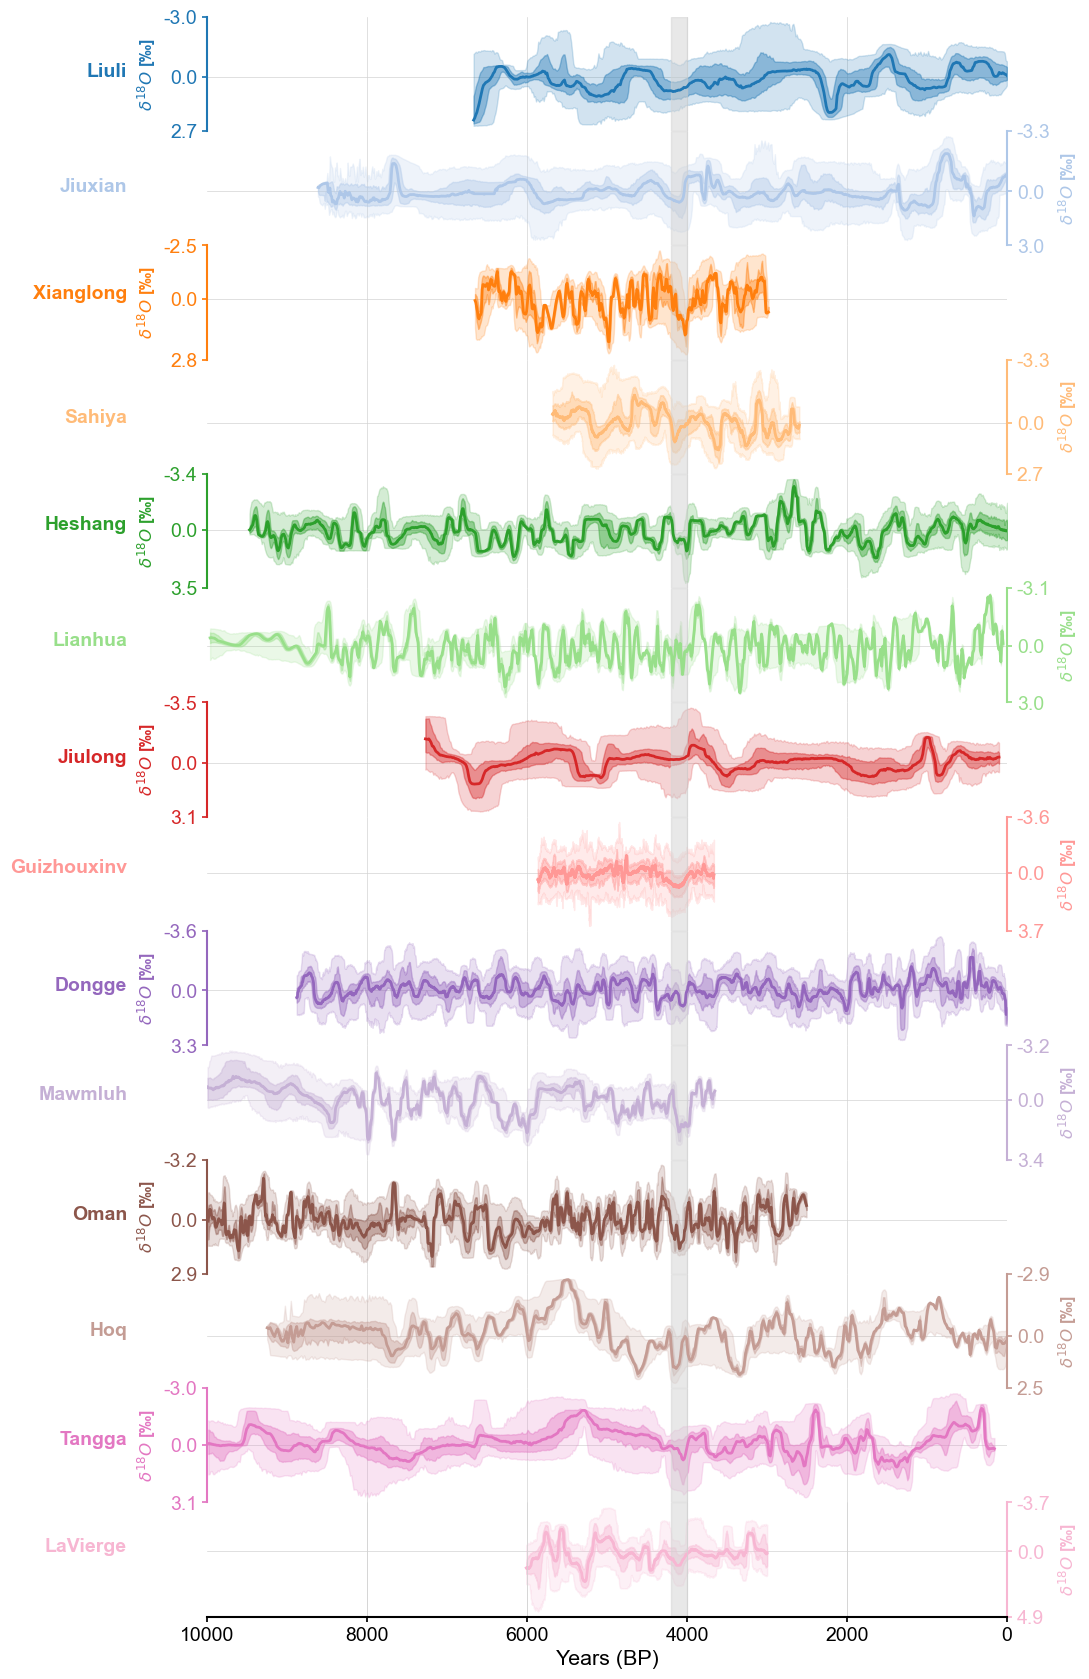

In [11]:
# Create a figure with a specified size
fig = plt.figure(figsize=(8, 16))

# Set up plot parameters
xlim = [0, 10000]
n_ts = len(preprocessed_ens_dict)
fill_between_alpha = 0.2
cmap = 'tab20'
labels = 'auto'
ylabel_fontsize = 12
spine_lw = 1.5
grid_lw = 0.5
label_x_loc = -0.15
v_shift_factor = 1
linewidth = 1.5

ax = {}
left = 0
width = 1
height = 1 / n_ts
bottom = 1

ens_dict = synthetic_ens_dict[1]
# Create a color palette with the same number of colors as the length of synthetic_ens_dict
colors = sns.color_palette('tab20', n_colors=len(ens_dict))
for idx, pair in enumerate(ens_dict.items()):
    color = colors[idx]
    label, ens = pair
    bottom -= height * v_shift_factor
    
    ax[idx] = fig.add_axes([left, bottom, width, height])


    # Plot the ensemble envelope
    ens.common_time(time_axis=preprocessed_series_dict[label].time, bounds_error=False).plot_envelope(ax=ax[idx], shade_clr=color, curve_clr=color)

    # Set plot properties for the main axis
    ax[idx].patch.set_alpha(0)
    ax[idx].set_xlim(xlim)
    time_label = 'Years (BP)'
    value_label = '$\delta^{18} O$ [‰]'
    ax[idx].set_ylabel(value_label, weight='bold', size=ylabel_fontsize)

    # Add labels to the plot
    trans = transforms.blended_transform_factory(ax[idx].transAxes, ax[idx].transData)
    ax[idx].text(-.1, 0, label, horizontalalignment='right', transform=trans, color=color, weight='bold')
    ylim = ax[idx].get_ylim()
    ax[idx].set_yticks([ylim[0], 0, ylim[-1]])
    ax[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[idx].grid(False)

    # Set spine and tick properties based on index
    if idx % 2 == 0:
        ax[idx].spines['left'].set_visible(True)
        ax[idx].spines['left'].set_linewidth(spine_lw)
        ax[idx].spines['left'].set_color(color)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].yaxis.set_label_position('left')
        ax[idx].yaxis.tick_left()
    else:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(True)
        ax[idx].spines['right'].set_linewidth(spine_lw)
        ax[idx].spines['right'].set_color(color)
        ax[idx].yaxis.set_label_position('right')
        ax[idx].yaxis.tick_right()

    ylim_mag = max(ylim) - min(ylim)
    offset = ylim_mag * .05

    # Set additional plot properties
    ax[idx].yaxis.label.set_color(color)
    ax[idx].tick_params(axis='y', colors=color)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].tick_params(axis='x', which='both', length=0)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels([])
    ax[idx].legend([])
    xt = ax[idx].get_xticks()[1:-1]
    for x in xt:
        ax[idx].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].axhline(y=0, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].invert_xaxis()
    ax[idx].invert_yaxis()
    ax[idx].axvspan(4200, 4000, color='lightgrey', alpha=0.5)

# Set up the x-axis label at the bottom
bottom -= height * (1 - v_shift_factor)
ax[n_ts] = fig.add_axes([left, bottom, width, height])
ax[n_ts].set_xlabel(time_label)
ax[n_ts].spines['left'].set_visible(False)
ax[n_ts].spines['right'].set_visible(False)
ax[n_ts].spines['bottom'].set_visible(True)
ax[n_ts].spines['bottom'].set_linewidth(spine_lw)
ax[n_ts].set_yticks([])
ax[n_ts].patch.set_alpha(0)
ax[n_ts].set_xlim(xlim)
ax[n_ts].grid(False)
ax[n_ts].tick_params(axis='x', which='both', length=3.5)
xt = ax[n_ts].get_xticks()[1:-1]
for x in xt:
    ax[n_ts].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
ax[n_ts].invert_xaxis()
ax[n_ts].invert_yaxis()

In [12]:
pyleo.savefig(fig,'../../figures/synthetic_stack_1.pdf')

Figure saved at: "../../figures/synthetic_stack_1.pdf"


SNR = 1.5

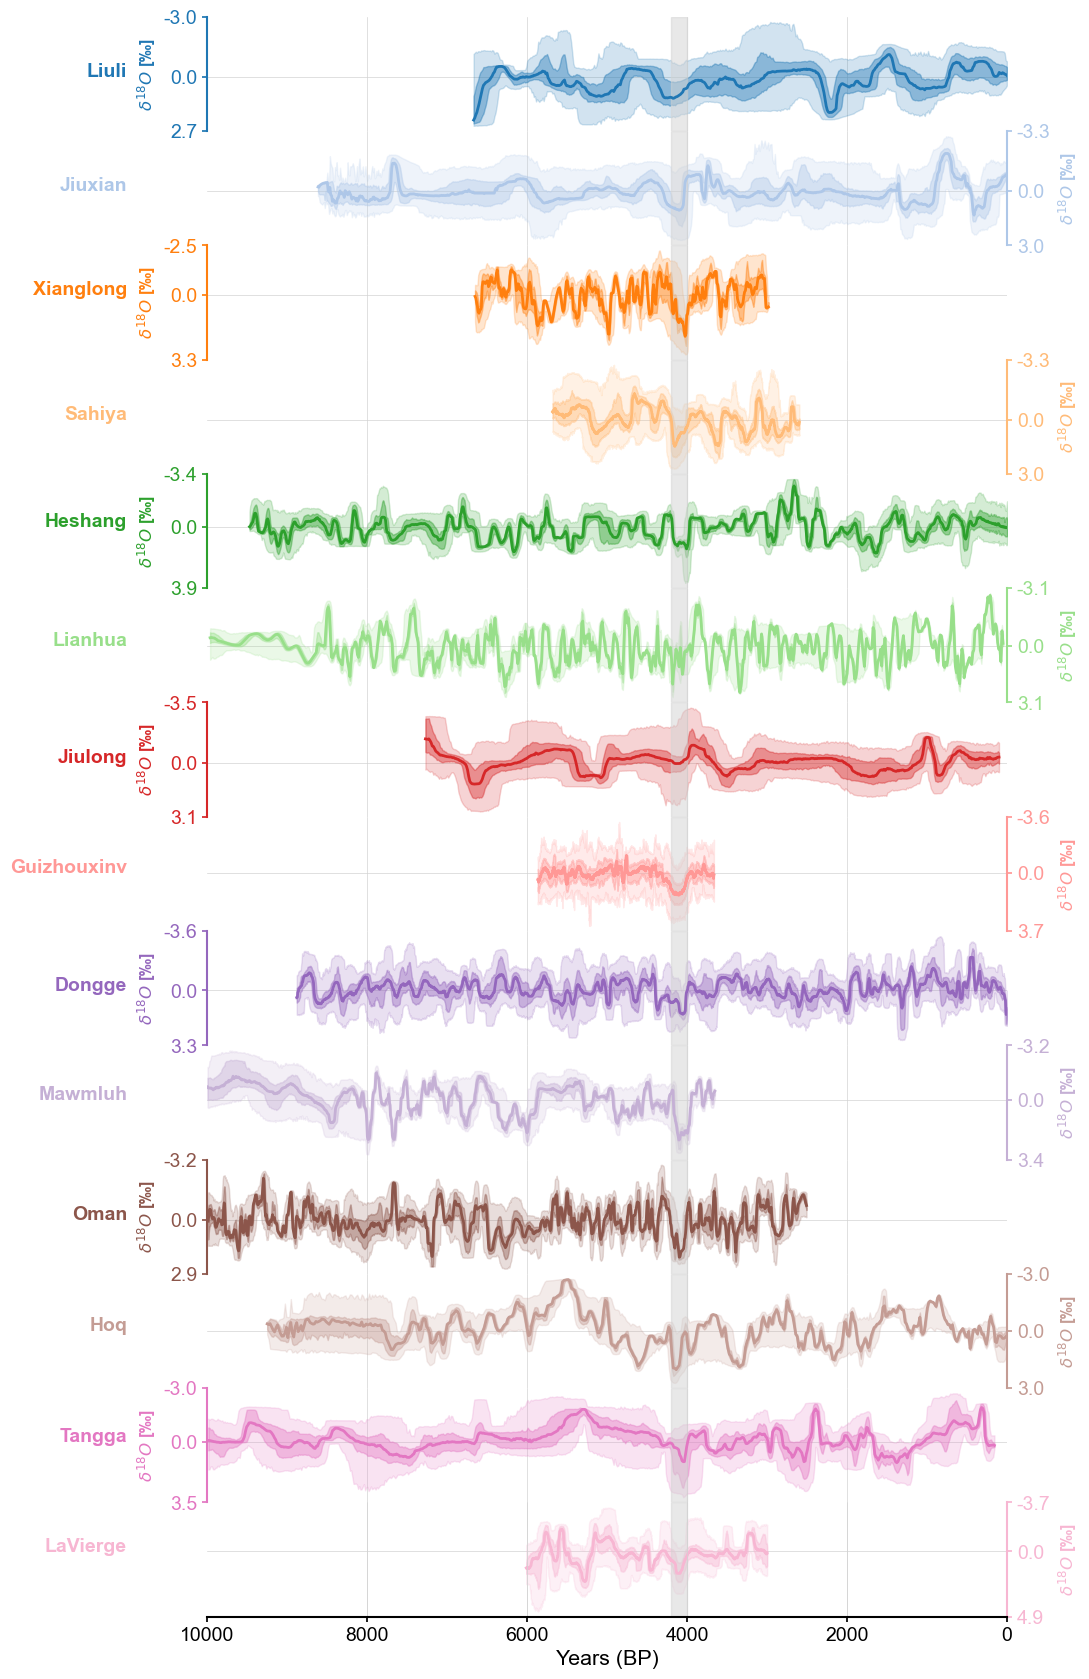

In [13]:
# Create a figure with a specified size
fig = plt.figure(figsize=(8, 16))

# Set up plot parameters
xlim = [0, 10000]
n_ts = len(preprocessed_ens_dict)
fill_between_alpha = 0.2
cmap = 'tab20'
labels = 'auto'
ylabel_fontsize = 12
spine_lw = 1.5
grid_lw = 0.5
label_x_loc = -0.15
v_shift_factor = 1
linewidth = 1.5

ax = {}
left = 0
width = 1
height = 1 / n_ts
bottom = 1

ens_dict = synthetic_ens_dict[1.5]
# Create a color palette with the same number of colors as the length of synthetic_ens_dict
colors = sns.color_palette('tab20', n_colors=len(ens_dict))
for idx, pair in enumerate(ens_dict.items()):
    color = colors[idx]
    label, ens = pair
    bottom -= height * v_shift_factor
    
    ax[idx] = fig.add_axes([left, bottom, width, height])


    # Plot the ensemble envelope
    ens.common_time(time_axis=preprocessed_series_dict[label].time, bounds_error=False).plot_envelope(ax=ax[idx], shade_clr=color, curve_clr=color)

    # Set plot properties for the main axis
    ax[idx].patch.set_alpha(0)
    ax[idx].set_xlim(xlim)
    time_label = 'Years (BP)'
    value_label = '$\delta^{18} O$ [‰]'
    ax[idx].set_ylabel(value_label, weight='bold', size=ylabel_fontsize)

    # Add labels to the plot
    trans = transforms.blended_transform_factory(ax[idx].transAxes, ax[idx].transData)
    ax[idx].text(-.1, 0, label, horizontalalignment='right', transform=trans, color=color, weight='bold')
    ylim = ax[idx].get_ylim()
    ax[idx].set_yticks([ylim[0], 0, ylim[-1]])
    ax[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[idx].grid(False)

    # Set spine and tick properties based on index
    if idx % 2 == 0:
        ax[idx].spines['left'].set_visible(True)
        ax[idx].spines['left'].set_linewidth(spine_lw)
        ax[idx].spines['left'].set_color(color)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].yaxis.set_label_position('left')
        ax[idx].yaxis.tick_left()
    else:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(True)
        ax[idx].spines['right'].set_linewidth(spine_lw)
        ax[idx].spines['right'].set_color(color)
        ax[idx].yaxis.set_label_position('right')
        ax[idx].yaxis.tick_right()

    ylim_mag = max(ylim) - min(ylim)
    offset = ylim_mag * .05

    # Set additional plot properties
    ax[idx].yaxis.label.set_color(color)
    ax[idx].tick_params(axis='y', colors=color)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].tick_params(axis='x', which='both', length=0)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels([])
    ax[idx].legend([])
    xt = ax[idx].get_xticks()[1:-1]
    for x in xt:
        ax[idx].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].axhline(y=0, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].invert_xaxis()
    ax[idx].invert_yaxis()
    ax[idx].axvspan(4200, 4000, color='lightgrey', alpha=0.5)

# Set up the x-axis label at the bottom
bottom -= height * (1 - v_shift_factor)
ax[n_ts] = fig.add_axes([left, bottom, width, height])
ax[n_ts].set_xlabel(time_label)
ax[n_ts].spines['left'].set_visible(False)
ax[n_ts].spines['right'].set_visible(False)
ax[n_ts].spines['bottom'].set_visible(True)
ax[n_ts].spines['bottom'].set_linewidth(spine_lw)
ax[n_ts].set_yticks([])
ax[n_ts].patch.set_alpha(0)
ax[n_ts].set_xlim(xlim)
ax[n_ts].grid(False)
ax[n_ts].tick_params(axis='x', which='both', length=3.5)
xt = ax[n_ts].get_xticks()[1:-1]
for x in xt:
    ax[n_ts].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
ax[n_ts].invert_xaxis()
ax[n_ts].invert_yaxis()

In [14]:
pyleo.savefig(fig,'../../figures/synthetic_stack_15.pdf')

Figure saved at: "../../figures/synthetic_stack_15.pdf"


SNR = 2

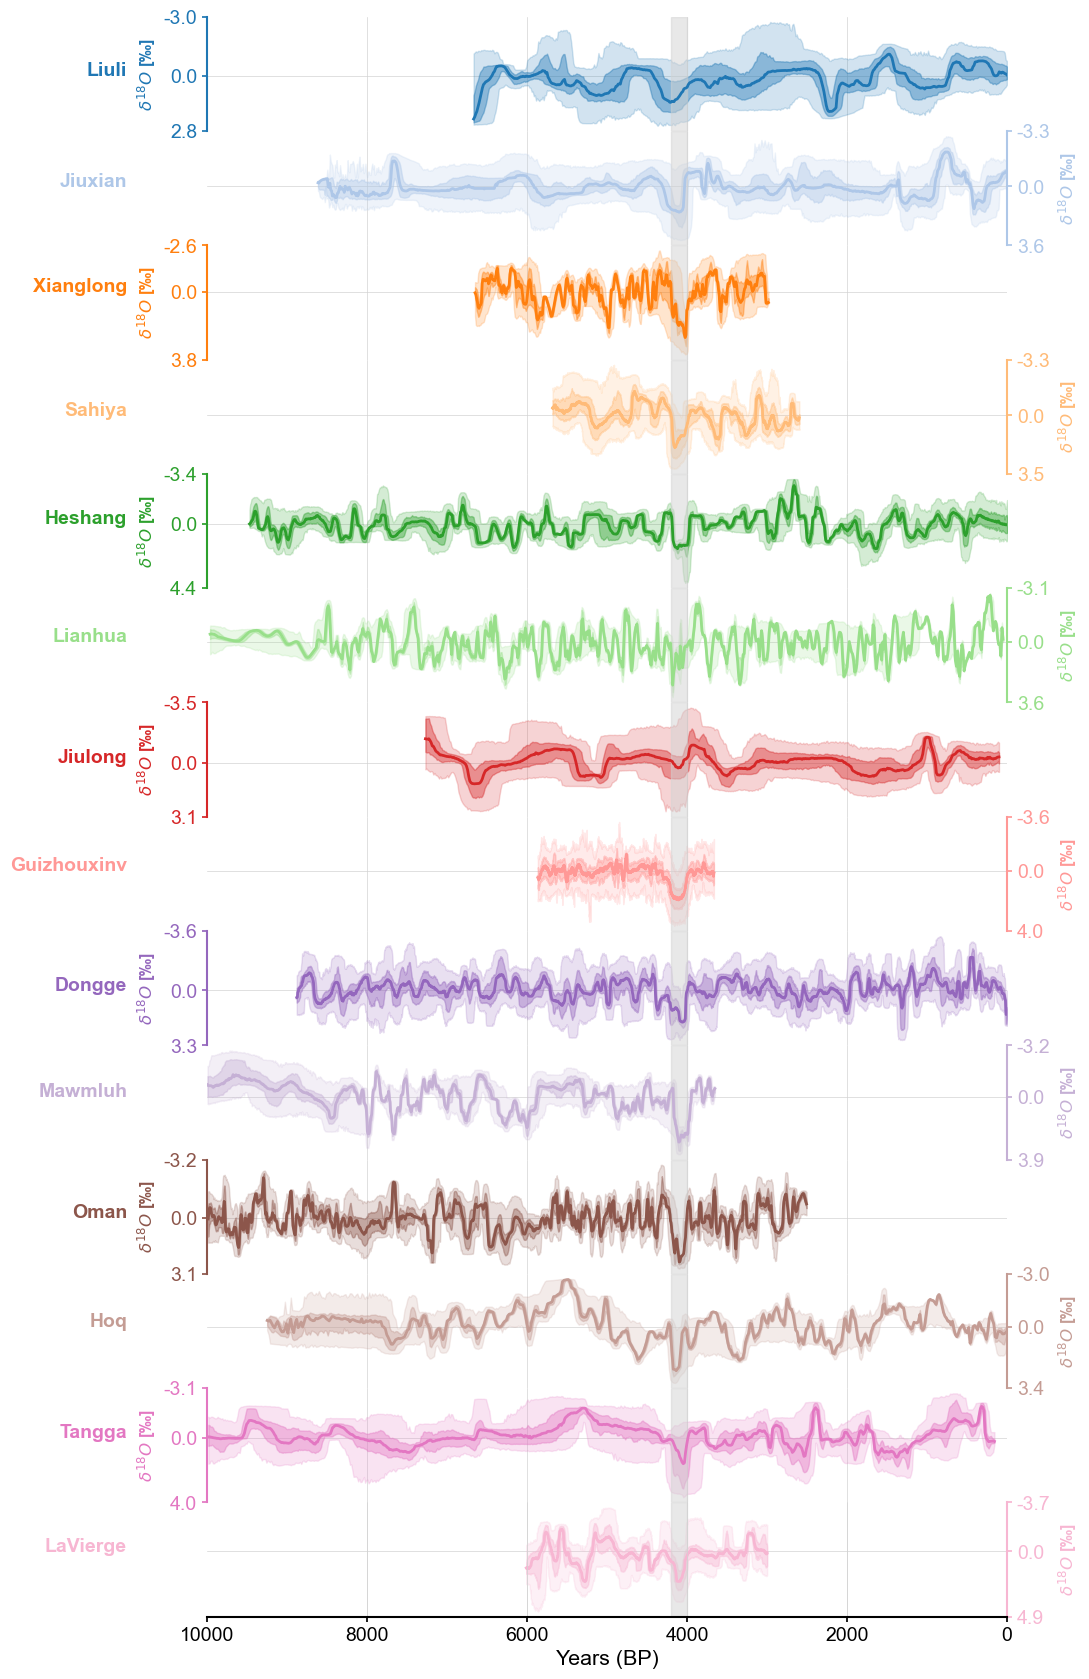

In [15]:
# Create a figure with a specified size
fig = plt.figure(figsize=(8, 16))

# Set up plot parameters
xlim = [0, 10000]
n_ts = len(preprocessed_ens_dict)
fill_between_alpha = 0.2
cmap = 'tab20'
labels = 'auto'
ylabel_fontsize = 12
spine_lw = 1.5
grid_lw = 0.5
label_x_loc = -0.15
v_shift_factor = 1
linewidth = 1.5

ax = {}
left = 0
width = 1
height = 1 / n_ts
bottom = 1

ens_dict = synthetic_ens_dict[2]
# Create a color palette with the same number of colors as the length of synthetic_ens_dict
colors = sns.color_palette('tab20', n_colors=len(ens_dict))
for idx, pair in enumerate(ens_dict.items()):
    color = colors[idx]
    label, ens = pair
    bottom -= height * v_shift_factor
    
    ax[idx] = fig.add_axes([left, bottom, width, height])


    # Plot the ensemble envelope
    ens.common_time(time_axis=preprocessed_series_dict[label].time, bounds_error=False).plot_envelope(ax=ax[idx], shade_clr=color, curve_clr=color)

    # Set plot properties for the main axis
    ax[idx].patch.set_alpha(0)
    ax[idx].set_xlim(xlim)
    time_label = 'Years (BP)'
    value_label = '$\delta^{18} O$ [‰]'
    ax[idx].set_ylabel(value_label, weight='bold', size=ylabel_fontsize)

    # Add labels to the plot
    trans = transforms.blended_transform_factory(ax[idx].transAxes, ax[idx].transData)
    ax[idx].text(-.1, 0, label, horizontalalignment='right', transform=trans, color=color, weight='bold')
    ylim = ax[idx].get_ylim()
    ax[idx].set_yticks([ylim[0], 0, ylim[-1]])
    ax[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[idx].grid(False)

    # Set spine and tick properties based on index
    if idx % 2 == 0:
        ax[idx].spines['left'].set_visible(True)
        ax[idx].spines['left'].set_linewidth(spine_lw)
        ax[idx].spines['left'].set_color(color)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].yaxis.set_label_position('left')
        ax[idx].yaxis.tick_left()
    else:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(True)
        ax[idx].spines['right'].set_linewidth(spine_lw)
        ax[idx].spines['right'].set_color(color)
        ax[idx].yaxis.set_label_position('right')
        ax[idx].yaxis.tick_right()

    ylim_mag = max(ylim) - min(ylim)
    offset = ylim_mag * .05

    # Set additional plot properties
    ax[idx].yaxis.label.set_color(color)
    ax[idx].tick_params(axis='y', colors=color)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].tick_params(axis='x', which='both', length=0)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels([])
    ax[idx].legend([])
    xt = ax[idx].get_xticks()[1:-1]
    for x in xt:
        ax[idx].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].axhline(y=0, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].invert_xaxis()
    ax[idx].invert_yaxis()
    ax[idx].axvspan(4200, 4000, color='lightgrey', alpha=0.5)

# Set up the x-axis label at the bottom
bottom -= height * (1 - v_shift_factor)
ax[n_ts] = fig.add_axes([left, bottom, width, height])
ax[n_ts].set_xlabel(time_label)
ax[n_ts].spines['left'].set_visible(False)
ax[n_ts].spines['right'].set_visible(False)
ax[n_ts].spines['bottom'].set_visible(True)
ax[n_ts].spines['bottom'].set_linewidth(spine_lw)
ax[n_ts].set_yticks([])
ax[n_ts].patch.set_alpha(0)
ax[n_ts].set_xlim(xlim)
ax[n_ts].grid(False)
ax[n_ts].tick_params(axis='x', which='both', length=3.5)
xt = ax[n_ts].get_xticks()[1:-1]
for x in xt:
    ax[n_ts].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
ax[n_ts].invert_xaxis()
ax[n_ts].invert_yaxis()

In [16]:
pyleo.savefig(fig,'../../figures/synthetic_stack_2.pdf')

Figure saved at: "../../figures/synthetic_stack_2.pdf"


SNR = 2.5

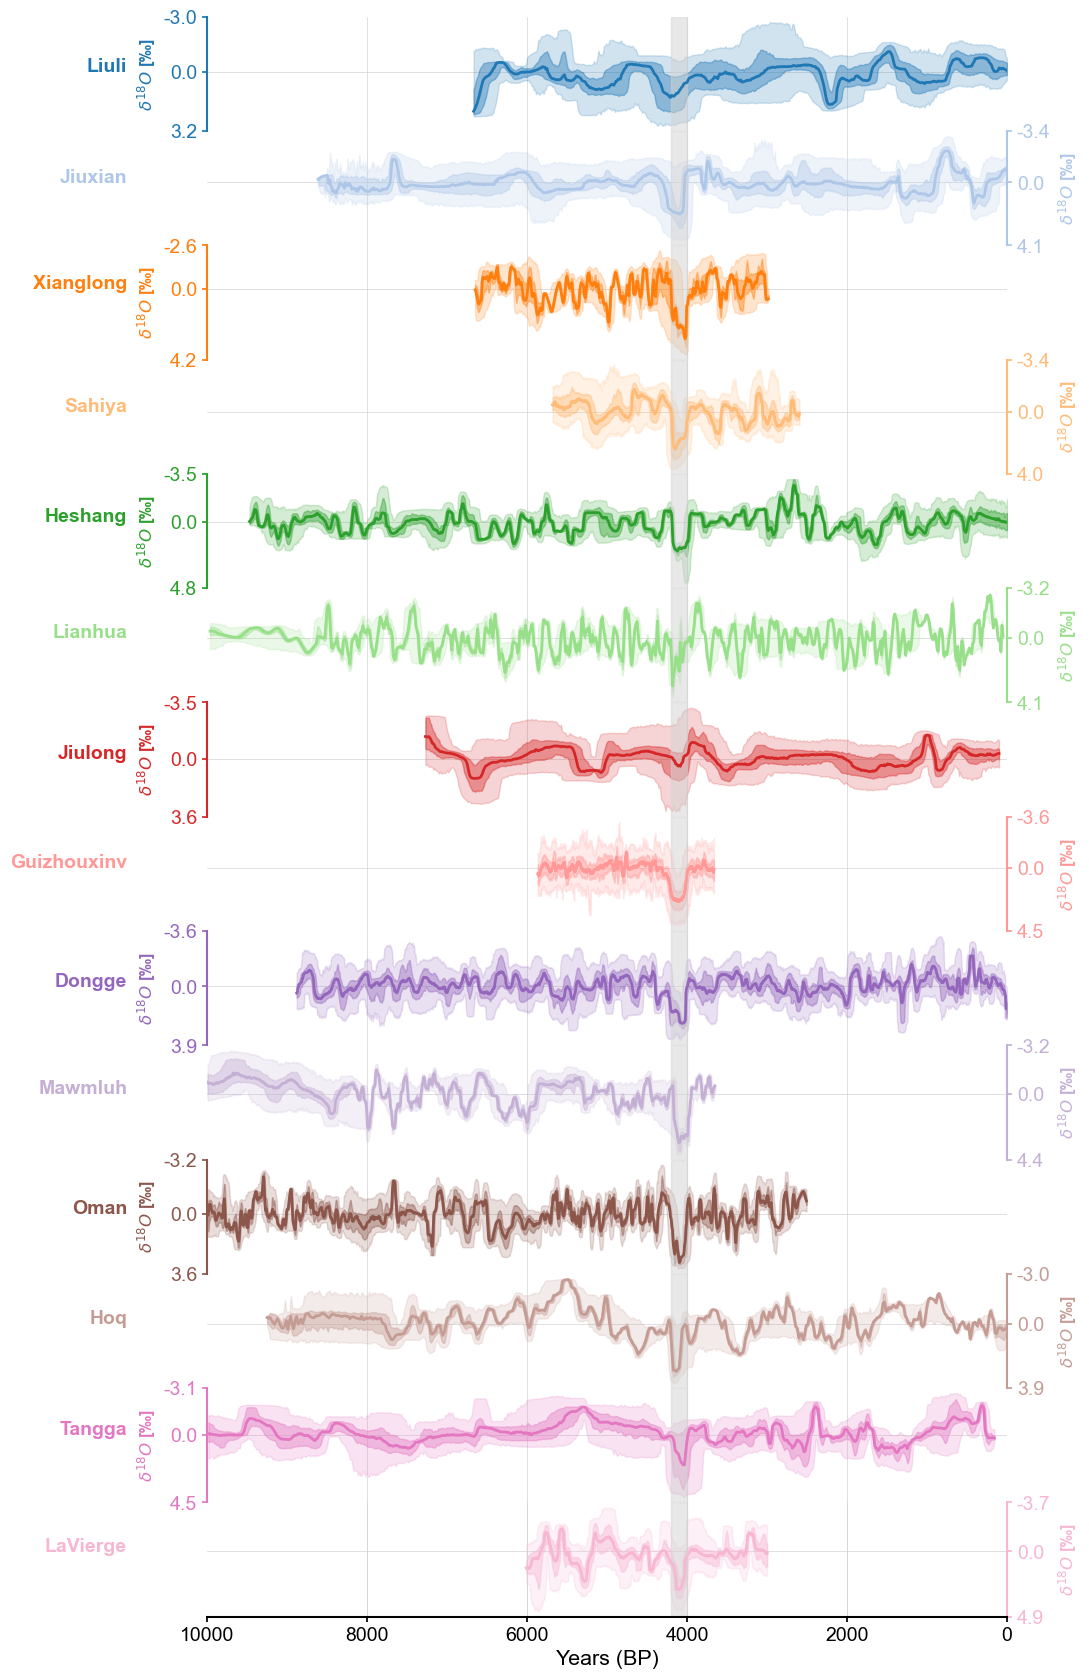

In [17]:
# Create a figure with a specified size
fig = plt.figure(figsize=(8, 16))

# Set up plot parameters
xlim = [0, 10000]
n_ts = len(preprocessed_ens_dict)
fill_between_alpha = 0.2
cmap = 'tab20'
labels = 'auto'
ylabel_fontsize = 12
spine_lw = 1.5
grid_lw = 0.5
label_x_loc = -0.15
v_shift_factor = 1
linewidth = 1.5

ax = {}
left = 0
width = 1
height = 1 / n_ts
bottom = 1

ens_dict = synthetic_ens_dict[2.5]
# Create a color palette with the same number of colors as the length of synthetic_ens_dict
colors = sns.color_palette('tab20', n_colors=len(ens_dict))
for idx, pair in enumerate(ens_dict.items()):
    color = colors[idx]
    label, ens = pair
    bottom -= height * v_shift_factor
    
    ax[idx] = fig.add_axes([left, bottom, width, height])


    # Plot the ensemble envelope
    ens.common_time(time_axis=preprocessed_series_dict[label].time, bounds_error=False).plot_envelope(ax=ax[idx], shade_clr=color, curve_clr=color)

    # Set plot properties for the main axis
    ax[idx].patch.set_alpha(0)
    ax[idx].set_xlim(xlim)
    time_label = 'Years (BP)'
    value_label = '$\delta^{18} O$ [‰]'
    ax[idx].set_ylabel(value_label, weight='bold', size=ylabel_fontsize)

    # Add labels to the plot
    trans = transforms.blended_transform_factory(ax[idx].transAxes, ax[idx].transData)
    ax[idx].text(-.1, 0, label, horizontalalignment='right', transform=trans, color=color, weight='bold')
    ylim = ax[idx].get_ylim()
    ax[idx].set_yticks([ylim[0], 0, ylim[-1]])
    ax[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[idx].grid(False)

    # Set spine and tick properties based on index
    if idx % 2 == 0:
        ax[idx].spines['left'].set_visible(True)
        ax[idx].spines['left'].set_linewidth(spine_lw)
        ax[idx].spines['left'].set_color(color)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].yaxis.set_label_position('left')
        ax[idx].yaxis.tick_left()
    else:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(True)
        ax[idx].spines['right'].set_linewidth(spine_lw)
        ax[idx].spines['right'].set_color(color)
        ax[idx].yaxis.set_label_position('right')
        ax[idx].yaxis.tick_right()

    ylim_mag = max(ylim) - min(ylim)
    offset = ylim_mag * .05

    # Set additional plot properties
    ax[idx].yaxis.label.set_color(color)
    ax[idx].tick_params(axis='y', colors=color)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].tick_params(axis='x', which='both', length=0)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels([])
    ax[idx].legend([])
    xt = ax[idx].get_xticks()[1:-1]
    for x in xt:
        ax[idx].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].axhline(y=0, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].invert_xaxis()
    ax[idx].invert_yaxis()
    ax[idx].axvspan(4200, 4000, color='lightgrey', alpha=0.5)

# Set up the x-axis label at the bottom
bottom -= height * (1 - v_shift_factor)
ax[n_ts] = fig.add_axes([left, bottom, width, height])
ax[n_ts].set_xlabel(time_label)
ax[n_ts].spines['left'].set_visible(False)
ax[n_ts].spines['right'].set_visible(False)
ax[n_ts].spines['bottom'].set_visible(True)
ax[n_ts].spines['bottom'].set_linewidth(spine_lw)
ax[n_ts].set_yticks([])
ax[n_ts].patch.set_alpha(0)
ax[n_ts].set_xlim(xlim)
ax[n_ts].grid(False)
ax[n_ts].tick_params(axis='x', which='both', length=3.5)
xt = ax[n_ts].get_xticks()[1:-1]
for x in xt:
    ax[n_ts].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
ax[n_ts].invert_xaxis()
ax[n_ts].invert_yaxis()

In [18]:
pyleo.savefig(fig,'../../figures/synthetic_stack_25.pdf')

Figure saved at: "../../figures/synthetic_stack_25.pdf"


SNR = 3

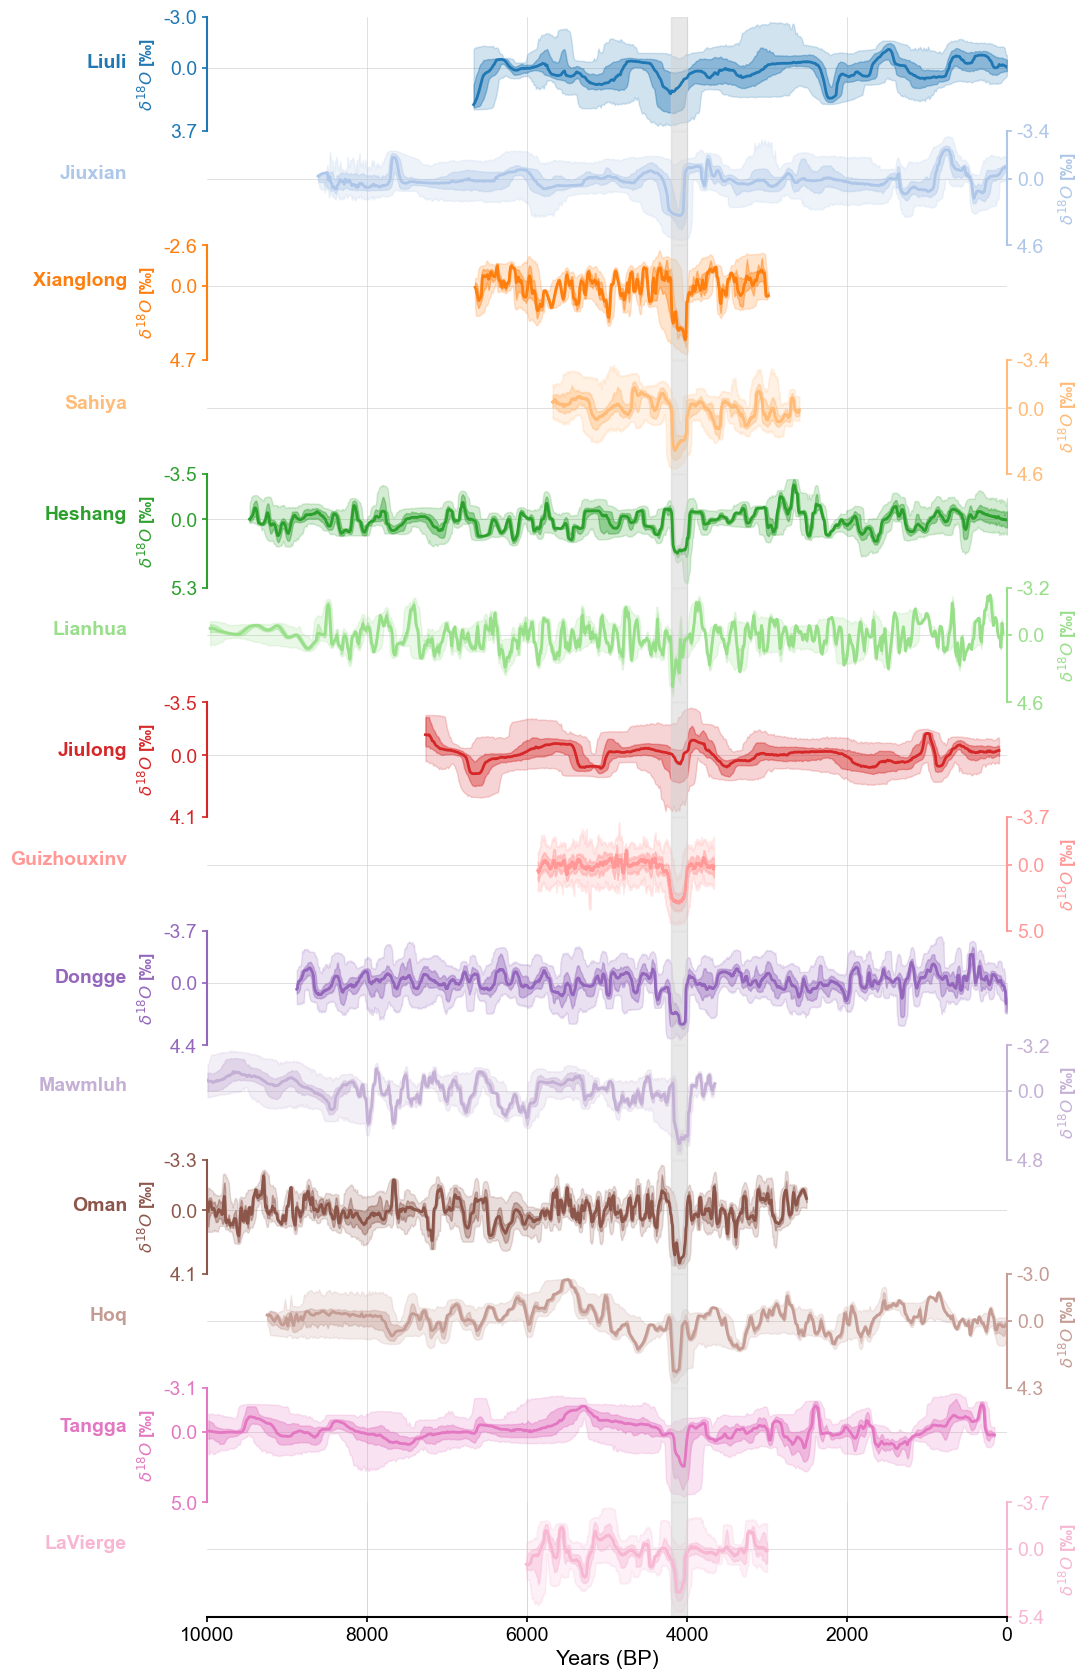

In [19]:
# Create a figure with a specified size
fig = plt.figure(figsize=(8, 16))

# Set up plot parameters
xlim = [0, 10000]
n_ts = len(preprocessed_ens_dict)
fill_between_alpha = 0.2
cmap = 'tab20'
labels = 'auto'
ylabel_fontsize = 12
spine_lw = 1.5
grid_lw = 0.5
label_x_loc = -0.15
v_shift_factor = 1
linewidth = 1.5

ax = {}
left = 0
width = 1
height = 1 / n_ts
bottom = 1

ens_dict = synthetic_ens_dict[3]
# Create a color palette with the same number of colors as the length of synthetic_ens_dict
colors = sns.color_palette('tab20', n_colors=len(ens_dict))
for idx, pair in enumerate(ens_dict.items()):
    color = colors[idx]
    label, ens = pair
    bottom -= height * v_shift_factor
    
    ax[idx] = fig.add_axes([left, bottom, width, height])


    # Plot the ensemble envelope
    ens.common_time(time_axis=preprocessed_series_dict[label].time, bounds_error=False).plot_envelope(ax=ax[idx], shade_clr=color, curve_clr=color)

    # Set plot properties for the main axis
    ax[idx].patch.set_alpha(0)
    ax[idx].set_xlim(xlim)
    time_label = 'Years (BP)'
    value_label = '$\delta^{18} O$ [‰]'
    ax[idx].set_ylabel(value_label, weight='bold', size=ylabel_fontsize)

    # Add labels to the plot
    trans = transforms.blended_transform_factory(ax[idx].transAxes, ax[idx].transData)
    ax[idx].text(-.1, 0, label, horizontalalignment='right', transform=trans, color=color, weight='bold')
    ylim = ax[idx].get_ylim()
    ax[idx].set_yticks([ylim[0], 0, ylim[-1]])
    ax[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[idx].grid(False)

    # Set spine and tick properties based on index
    if idx % 2 == 0:
        ax[idx].spines['left'].set_visible(True)
        ax[idx].spines['left'].set_linewidth(spine_lw)
        ax[idx].spines['left'].set_color(color)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].yaxis.set_label_position('left')
        ax[idx].yaxis.tick_left()
    else:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(True)
        ax[idx].spines['right'].set_linewidth(spine_lw)
        ax[idx].spines['right'].set_color(color)
        ax[idx].yaxis.set_label_position('right')
        ax[idx].yaxis.tick_right()

    ylim_mag = max(ylim) - min(ylim)
    offset = ylim_mag * .05

    # Set additional plot properties
    ax[idx].yaxis.label.set_color(color)
    ax[idx].tick_params(axis='y', colors=color)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].tick_params(axis='x', which='both', length=0)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels([])
    ax[idx].legend([])
    xt = ax[idx].get_xticks()[1:-1]
    for x in xt:
        ax[idx].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].axhline(y=0, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].invert_xaxis()
    ax[idx].invert_yaxis()
    ax[idx].axvspan(4200, 4000, color='lightgrey', alpha=0.5)

# Set up the x-axis label at the bottom
bottom -= height * (1 - v_shift_factor)
ax[n_ts] = fig.add_axes([left, bottom, width, height])
ax[n_ts].set_xlabel(time_label)
ax[n_ts].spines['left'].set_visible(False)
ax[n_ts].spines['right'].set_visible(False)
ax[n_ts].spines['bottom'].set_visible(True)
ax[n_ts].spines['bottom'].set_linewidth(spine_lw)
ax[n_ts].set_yticks([])
ax[n_ts].patch.set_alpha(0)
ax[n_ts].set_xlim(xlim)
ax[n_ts].grid(False)
ax[n_ts].tick_params(axis='x', which='both', length=3.5)
xt = ax[n_ts].get_xticks()[1:-1]
for x in xt:
    ax[n_ts].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
ax[n_ts].invert_xaxis()
ax[n_ts].invert_yaxis()

In [20]:
pyleo.savefig(fig,'../../figures/synthetic_stack_3.pdf')

Figure saved at: "../../figures/synthetic_stack_3.pdf"
